<a href="https://colab.research.google.com/github/Nadil-K/5g-energy-consumption-modeling/blob/main/Notebooks/Samith/XGBoost_Basestations_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
import gc
import os
import itertools
import pickle
import re
import time

import warnings
warnings.filterwarnings('ignore')

from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
%matplotlib inline

from functools import reduce
from tqdm import tqdm
from itertools import cycle
from scipy import stats
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import ensemble
from sklearn import decomposition
from sklearn import tree

import lightgbm as lgb
import xgboost as xgb

pd.set_option("display.max_columns", None)

plt.style.use("ggplot")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Loading

In [ ]:
pcp_df = pd.read_csv("/content/drive/MyDrive/competitions/input/power_consumption_prediction.csv")
cl_df = pd.read_csv("/content/drive/MyDrive/competitions/input/CLdata.csv")
bs_df = pd.read_csv("/content/drive/MyDrive/competitions/input/BSinfo.csv")
ec_df  = pd.read_csv("/content/drive/MyDrive/competitions/input/ECdata.csv")
ss_df = pd.read_csv("/content/drive/MyDrive/competitions/input/SampleSubmission.csv")

pcp_df.shape, cl_df.shape, bs_df.shape, ec_df.shape, ss_df.shape

((26139, 17), (125575, 10), (1217, 8), (92629, 3), (26139, 4))

In [ ]:
ec_df.head()

,Time,BS,Energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [ ]:
cl_df.head()

,Time,BS,CellName,load,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
bs_df.head()

,BS,CellName,RUType,Mode,Frequency,Bandwidth,Antennas,TXpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [ ]:
pcp_df.head()

,Time,BS,load,TXpower,Frequency,Bandwidth,CellCount,ESMode1,ESMode2,ESMode3,ESMode4,ESMode5,ESMode6,RUType,Mode,Antennas,Energy
0,2023-01-01 10:00:00,100,0.071930,6.875934,532.0,20,1,0.0,0.0,0.0,0,0.0,0.0,4,2,2,NaN
1,2023-01-01 10:00:00,101,0.016970,6.875934,532.0,20,1,0.0,0.0,0.0,0,0.0,0.0,4,2,2,NaN
2,2023-01-01 10:00:00,105,0.166205,6.875934,365.0,20,2,0.0,0.0,0.0,0,0.0,0.0,1,2,2,NaN
3,2023-01-01 10:00:00,108,0.551320,6.875934,365.0,20,1,0.0,0.0,0.0,0,0.0,0.0,1,2,2,NaN
4,2023-01-01 10:00:00,117,0.203220,6.427504,189.0,10,1,0.0,0.0,0.0,0,0.0,0.0,5,2,2,NaN


In [ ]:
# pcp_df['w'].value_counts()

## Data Pre-Processing

In [ ]:
def rename_columns(df):
    df.rename(columns=lambda x: x.lower().replace(' ', '_'), inplace=True)
    return df

In [ ]:
pcp_df = rename_columns(pcp_df)
cl_df = rename_columns(cl_df)
bs_df = rename_columns(bs_df)
ec_df = rename_columns(ec_df)

In [ ]:
cl_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6
0,1/1/2023 1:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0
1,1/1/2023 2:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0
2,1/1/2023 3:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0
3,1/1/2023 4:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0
4,1/1/2023 5:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0


In [ ]:
bs_df.head()

,bs,cellname,rutype,mode,frequency,bandwidth,antennas,txpower
0,B_0,Cell0,Type1,Mode2,365.0,20,4,6.875934
1,B_1,Cell0,Type2,Mode2,532.0,20,4,6.875934
2,B_2,Cell0,Type1,Mode2,365.0,20,4,6.875934
3,B_3,Cell0,Type2,Mode2,532.0,20,4,6.875934
4,B_4,Cell0,Type2,Mode2,532.0,20,4,6.875934


In [ ]:
ec_df.head()

,time,bs,energy
0,1/1/2023 1:00,B_0,64.275037
1,1/1/2023 2:00,B_0,55.904335
2,1/1/2023 3:00,B_0,57.698057
3,1/1/2023 4:00,B_0,55.156951
4,1/1/2023 5:00,B_0,56.053812


In [ ]:
pcp_df.head()

,time,bs,load,txpower,frequency,bandwidth,cellcount,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,antennas,energy
0,2023-01-01 10:00:00,100,0.071930,6.875934,532.0,20,1,0.0,0.0,0.0,0,0.0,0.0,4,2,2,NaN
1,2023-01-01 10:00:00,101,0.016970,6.875934,532.0,20,1,0.0,0.0,0.0,0,0.0,0.0,4,2,2,NaN
2,2023-01-01 10:00:00,105,0.166205,6.875934,365.0,20,2,0.0,0.0,0.0,0,0.0,0.0,1,2,2,NaN
3,2023-01-01 10:00:00,108,0.551320,6.875934,365.0,20,1,0.0,0.0,0.0,0,0.0,0.0,1,2,2,NaN
4,2023-01-01 10:00:00,117,0.203220,6.427504,189.0,10,1,0.0,0.0,0.0,0,0.0,0.0,5,2,2,NaN


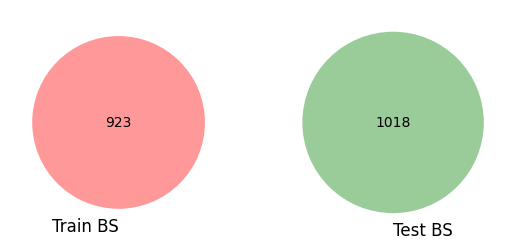

In [ ]:
train_bs_set = set(ec_df['bs'].values.tolist())
test_bs_set = set(pcp_df['bs'].values.tolist())

venn2([train_bs_set, test_bs_set], ('Train BS', 'Test BS'))
plt.show()

In [ ]:
cl_df['time'] = pd.to_datetime(cl_df['time'])
ec_df['time'] = pd.to_datetime(ec_df['time'])
pcp_df['time'] = pd.to_datetime(pcp_df['time'])

In [ ]:
cl_bs_df = cl_df.merge(bs_df, on=['bs', 'cellname'], how='left')
cl_bs_df.head()

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.0,20,4,6.875934


In [ ]:
cl_bs_df[cl_bs_df['bs'] == 'B_0']

,time,bs,cellname,load,esmode1,esmode2,esmode3,esmode4,esmode5,esmode6,rutype,mode,frequency,bandwidth,antennas,txpower
0,2023-01-01 01:00:00,B_0,Cell0,0.487936,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
1,2023-01-01 02:00:00,B_0,Cell0,0.344468,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
2,2023-01-01 03:00:00,B_0,Cell0,0.193766,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
3,2023-01-01 04:00:00,B_0,Cell0,0.222383,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
4,2023-01-01 05:00:00,B_0,Cell0,0.175436,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,365.00,20,4,6.875934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118787,2023-01-02 19:00:00,B_0,Cell1,0.206135,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118788,2023-01-02 20:00:00,B_0,Cell1,0.152981,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118789,2023-01-02 21:00:00,B_0,Cell1,0.150808,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504
118790,2023-01-02 22:00:00,B_0,Cell1,0.289731,0.0,0.0,0.0,0,0.0,0.0,Type1,Mode2,426.98,2,4,7.327504


In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique()

bs
B_0       2
B_1       1
B_10      2
B_100     1
B_1000    1
         ..
B_995     1
B_996     1
B_997     1
B_998     1
B_999     1
Name: cellname, Length: 1020, dtype: int64

In [ ]:
cl_bs_df.groupby("bs")['cellname'].nunique().value_counts()

1    827
2    191
4      2
Name: cellname, dtype: int64

In [ ]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [ ]:
cl_bs_df = cl_bs_df.pivot(
    index=['time', 'bs'],
    columns=['cellname'],
    values=['load', 'esmode1', 'esmode2', 'esmode3',
       'esmode4', 'esmode5', 'esmode6', 'frequency',
       'bandwidth', 'antennas', 'txpower'],
).reset_index()

cl_bs_df.columns = ['_'.join([str(i) for i in x]) for x in cl_bs_df.columns]
cl_bs_df.columns = cl_bs_df.columns.str.strip('_')
cl_bs_df = rename_columns(cl_bs_df)
cl_bs_df = cl_bs_df.merge(bs_df.groupby('bs')[['rutype', 'mode']].first().reset_index(), on='bs', how='left')

In [ ]:
cl_bs_df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2


In [ ]:
cl_bs_df.describe()

,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3
count,118768.000000,6711.000000,48.000000,48.000000,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.0,6711.0,48.0,48.0,118768.000000,6711.0,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.00,48.00,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.0,48.0,118768.000000,6711.000000,48.000000,48.000000
mean,0.246362,0.111214,0.070212,0.081115,0.042145,0.004985,0.0,0.0,0.038640,0.003311,0.0,0.0,0.000082,0.000135,0.0,0.0,0.0,0.0,0.0,0.0,0.000012,0.0,0.0,0.0,0.019168,0.386253,0.0,0.0,373.152776,379.542459,426.98,426.98,16.323740,6.338251,2.0,2.0,2.493079,2.218149,2.0,2.0,6.728786,7.028953,6.877429,6.877429
std,0.239354,0.091569,0.023807,0.038373,0.194184,0.064911,0.0,0.0,0.186785,0.052831,0.0,0.0,0.002439,0.002422,0.0,0.0,0.0,0.0,0.0,0.0,0.002882,0.0,0.0,0.0,0.112214,0.395205,0.0,0.0,145.409519,102.348829,0.00,0.00,5.238965,6.209317,0.0,0.0,4.617650,0.755766,0.0,0.0,0.330830,0.386024,0.000000,0.000000
min,0.000000,0.008190,0.045942,0.045904,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,155.600000,155.600000,426.98,426.98,2.000000,2.000000,2.0,2.0,1.000000,1.000000,2.0,2.0,5.381166,6.427504,6.877429,6.877429
25%,0.055714,0.051894,0.054442,0.051822,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,189.000000,365.000000,426.98,426.98,10.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.427504,6.761584,6.877429,6.877429
50%,0.162470,0.079423,0.066760,0.067856,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.275973,0.0,0.0,365.000000,426.980000,426.98,426.98,20.000000,2.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
75%,0.367142,0.138202,0.079385,0.095495,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.803992,0.0,0.0,532.000000,426.980000,426.98,426.98,20.000000,10.000000,2.0,2.0,2.000000,2.000000,2.0,2.0,6.875934,7.325859,6.877429,6.877429
max,0.993957,0.891770,0.174846,0.196519,1.000000,1.000000,0.0,0.0,1.000000,1.000000,0.0,0.0,0.154563,0.062805,0.0,0.0,0.0,0.0,0.0,0.0,0.768070,0.0,0.0,0.0,0.931032,0.927924,0.0,0.0,979.998000,697.002000,426.98,426.98,20.000000,20.000000,2.0,2.0,64.000000,8.000000,2.0,2.0,8.375336,7.877728,6.877429,6.877429


In [ ]:
ec_df.head()

,time,bs,energy
0,2023-01-01 01:00:00,B_0,64.275037
1,2023-01-01 02:00:00,B_0,55.904335
2,2023-01-01 03:00:00,B_0,57.698057
3,2023-01-01 04:00:00,B_0,55.156951
4,2023-01-01 05:00:00,B_0,56.053812


In [ ]:
df = cl_bs_df.merge(ec_df, on=['time', 'bs'], how='left')

In [ ]:
df.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode3_cell0,esmode3_cell1,esmode3_cell2,esmode3_cell3,esmode4_cell0,esmode4_cell1,esmode4_cell2,esmode4_cell3,esmode5_cell0,esmode5_cell1,esmode5_cell2,esmode5_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,30.343797
3,2023-01-01 01:00:00,B_100,0.011220,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,NaN
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,15.545590


In [ ]:
df['energy'].isna().value_counts()

False    92629
True     26139
Name: energy, dtype: int64

In [ ]:
df['split'] = df['energy'].isna().apply(lambda x: 'test' if x == True else 'train')

In [ ]:
ss_df.shape

(26139, 4)

In [ ]:
ec_df.shape

(92629, 3)

## EDA

In [ ]:
df['energy'].describe()

count    92629.000000
mean        28.138997
std         13.934645
min          0.747384
25%         18.236173
50%         24.065770
75%         35.724963
max        100.000000
Name: energy, dtype: float64

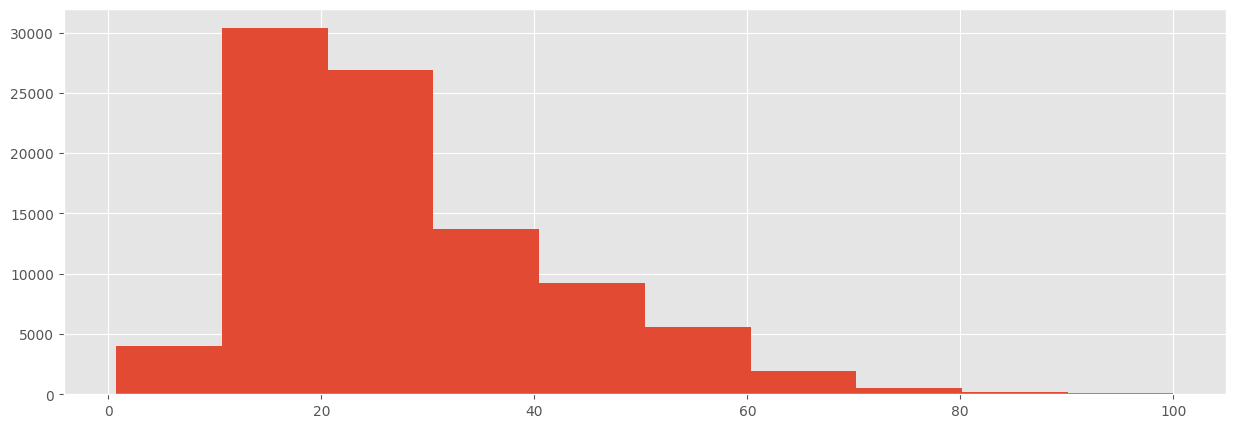

In [ ]:
plt.figure(figsize=(15, 5))
df['energy'].hist()
plt.show()

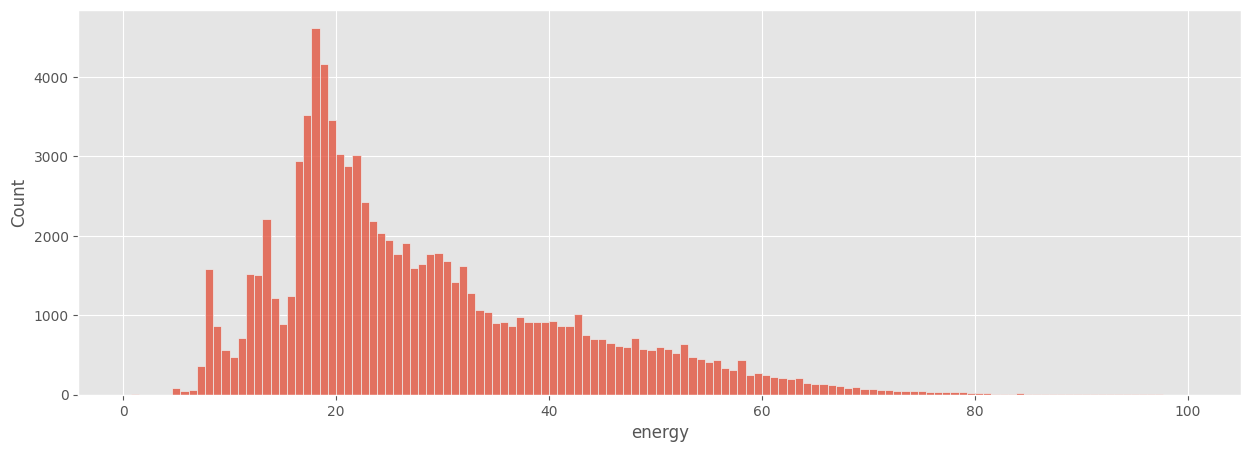

In [ ]:
plt.figure(figsize=(15, 5))
sns.histplot(df['energy'])
plt.show()

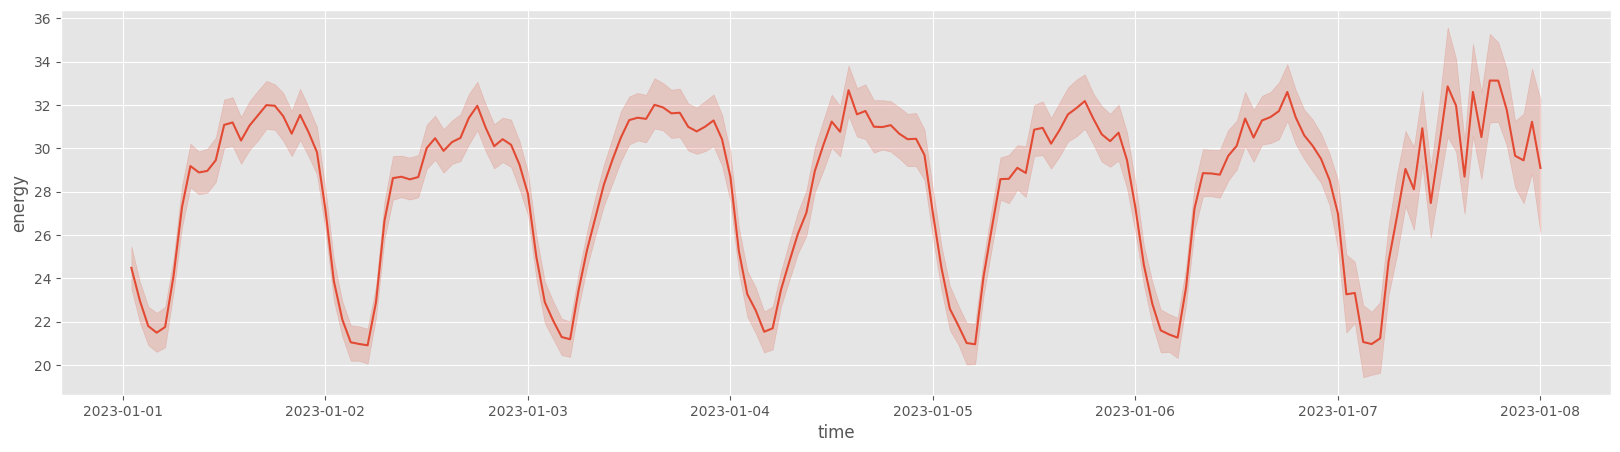

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy')
plt.show()

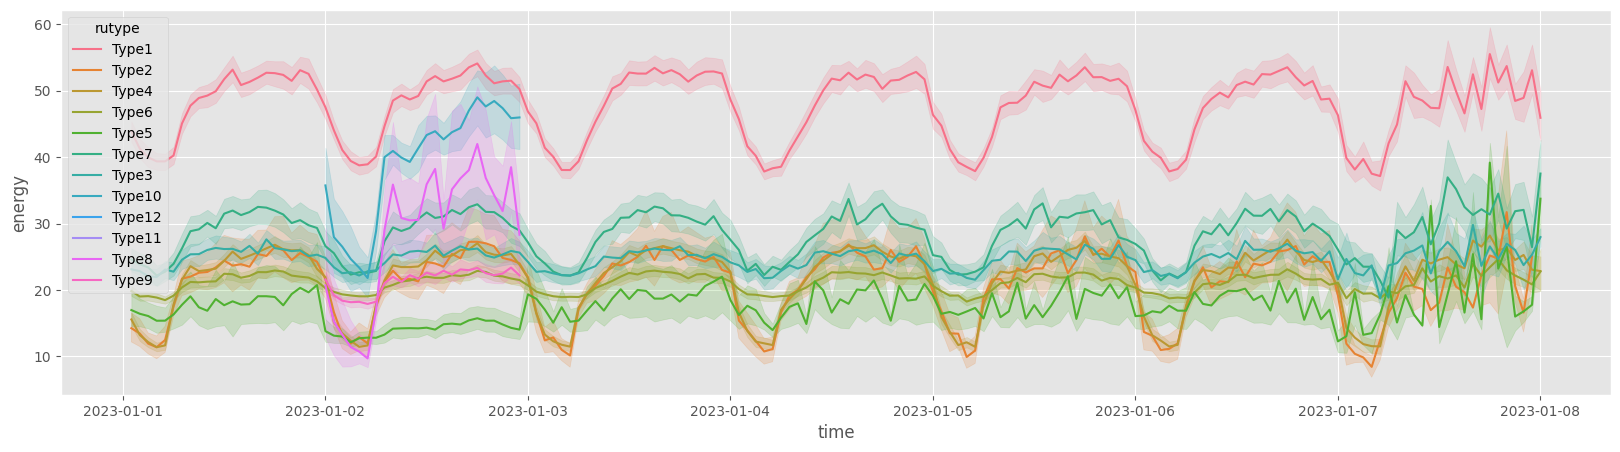

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='rutype')
plt.show()

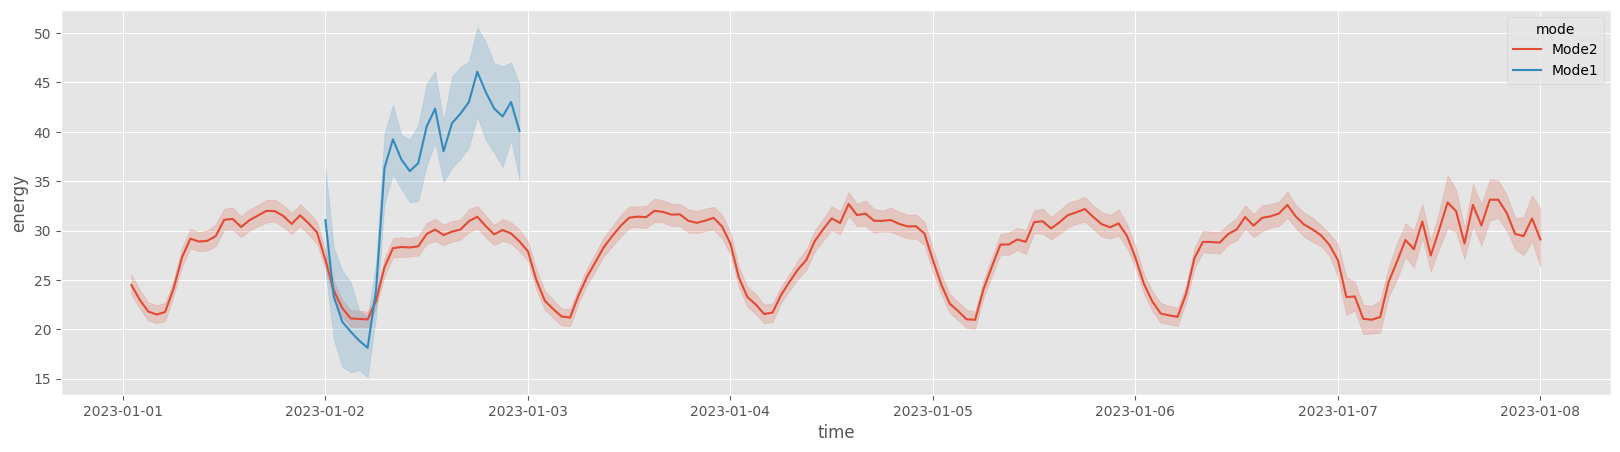

In [ ]:
plt.figure(figsize=(20, 5))
sns.lineplot(data=df, x='time', y='energy', hue='mode')
plt.show()

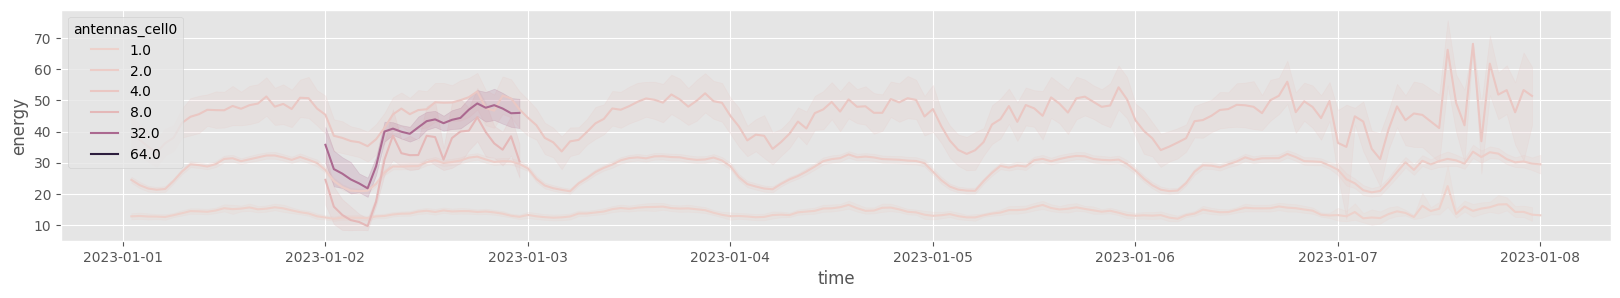

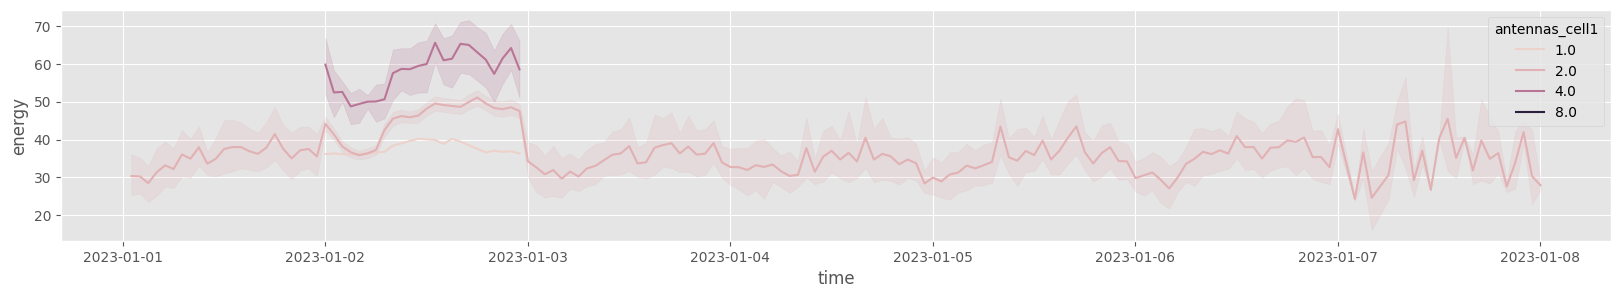

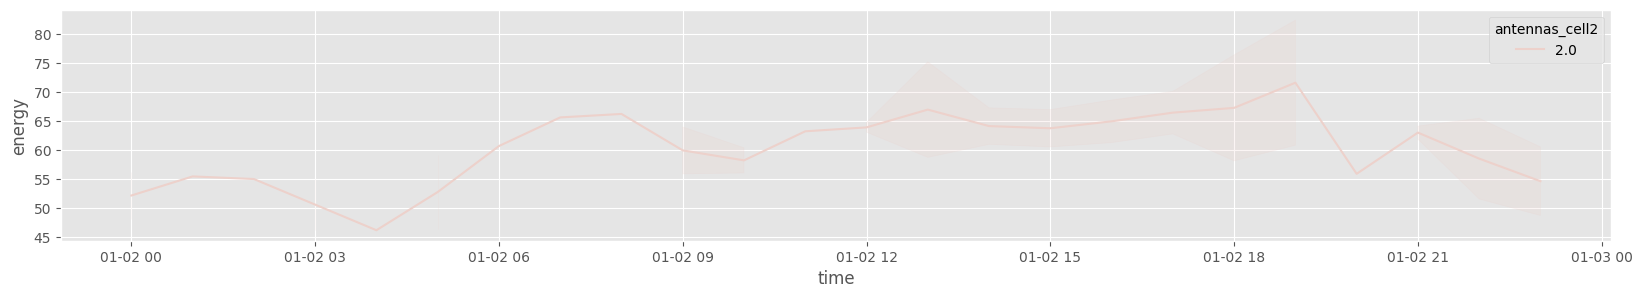

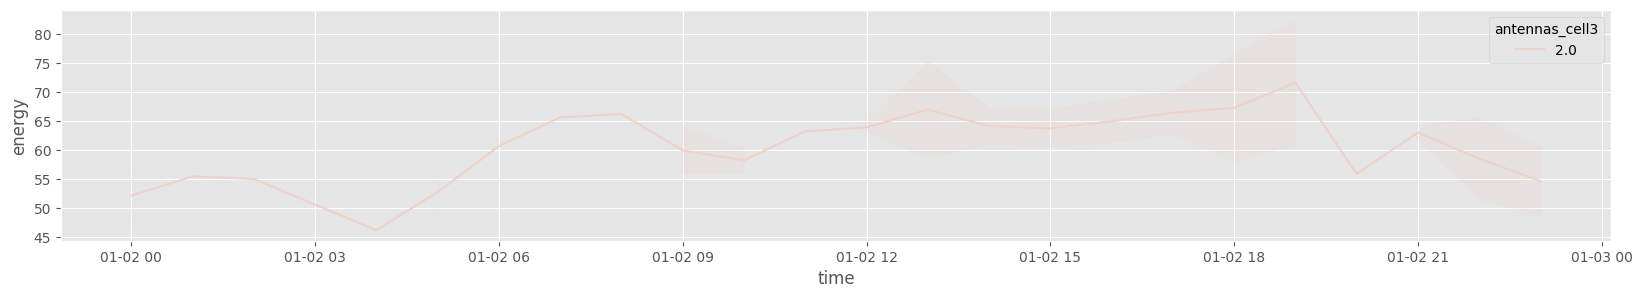

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='antennas_cell3')
plt.show()

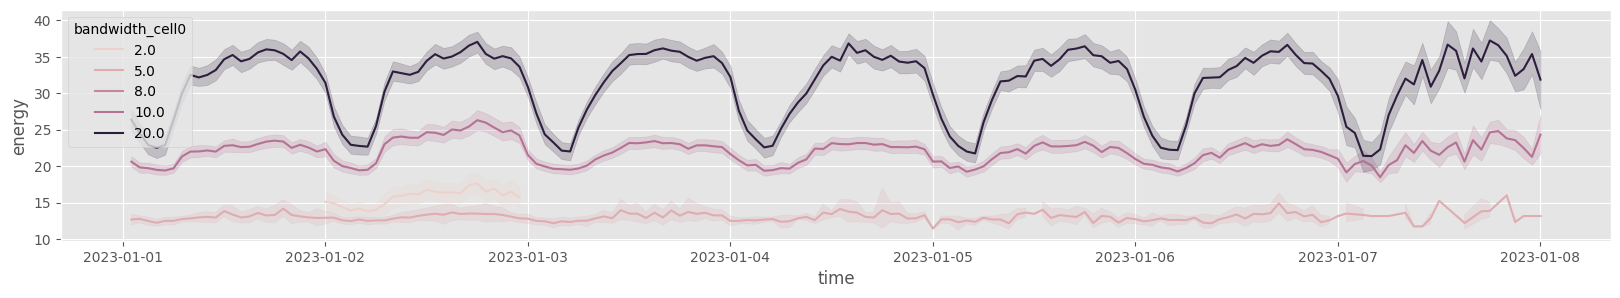

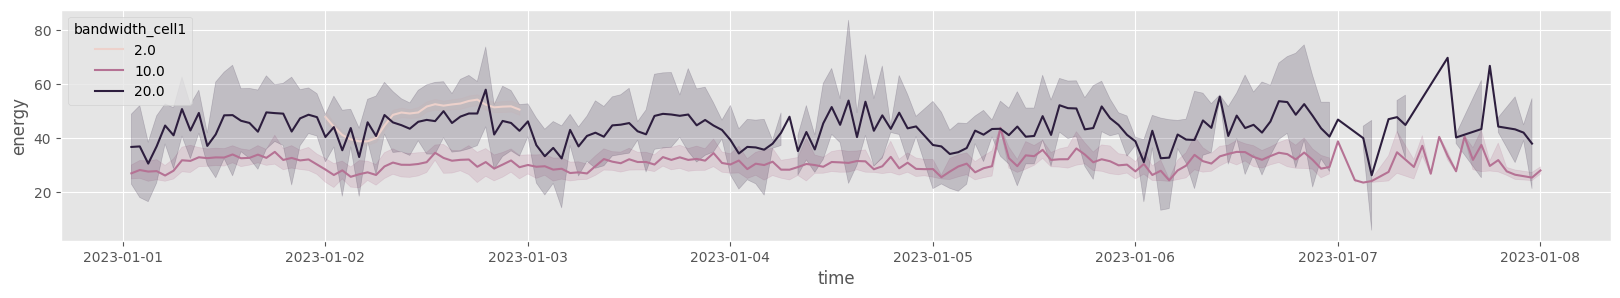

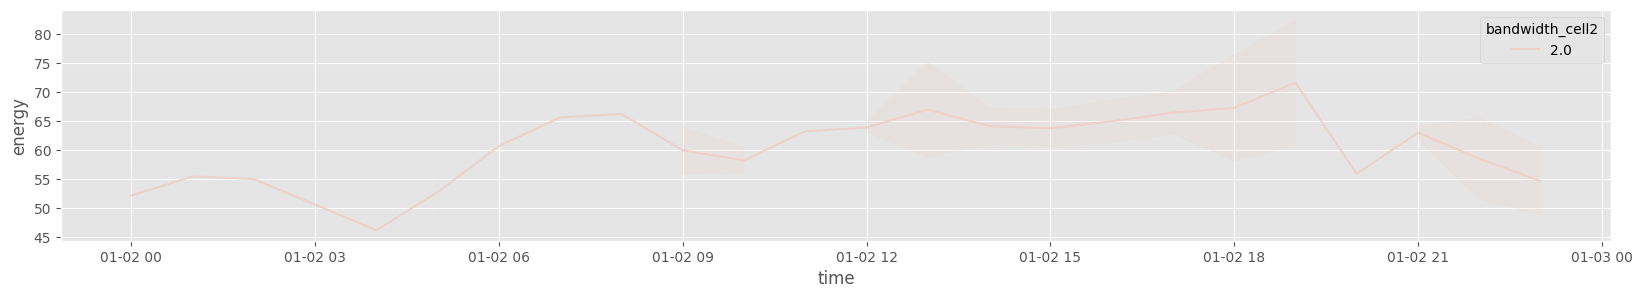

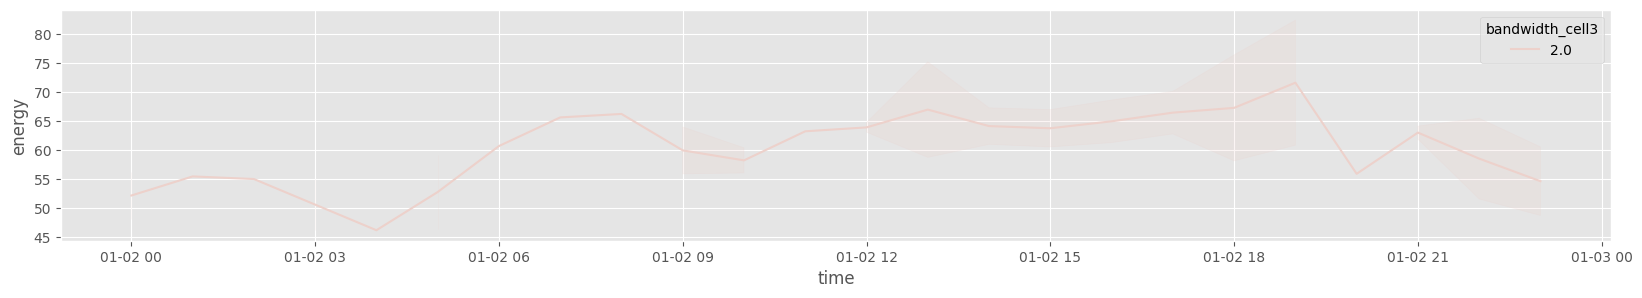

In [ ]:
plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell0')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell1')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell2')
plt.show()

plt.figure(figsize=(20, 3))
sns.lineplot(data=df, x='time', y='energy', hue='bandwidth_cell3')
plt.show()

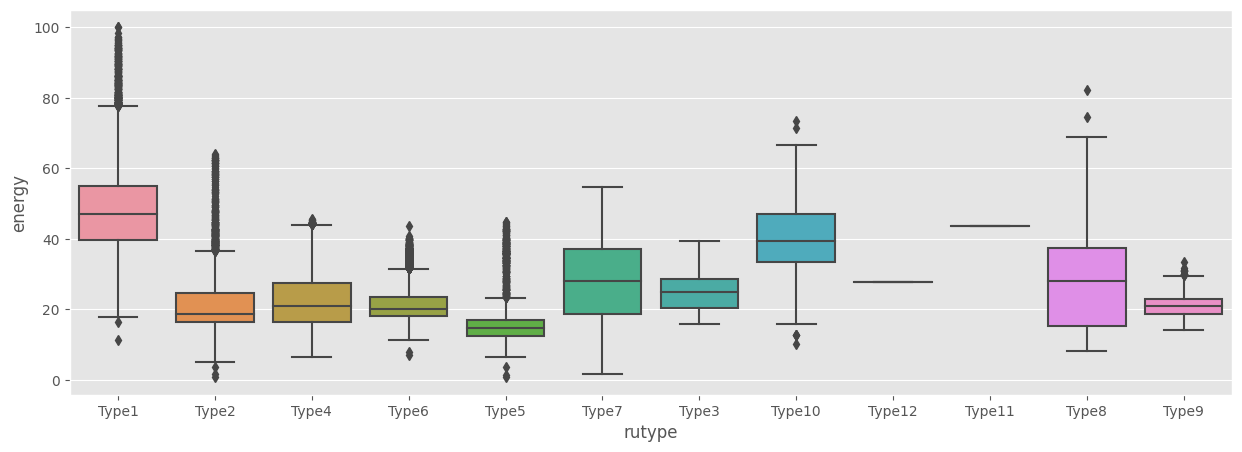

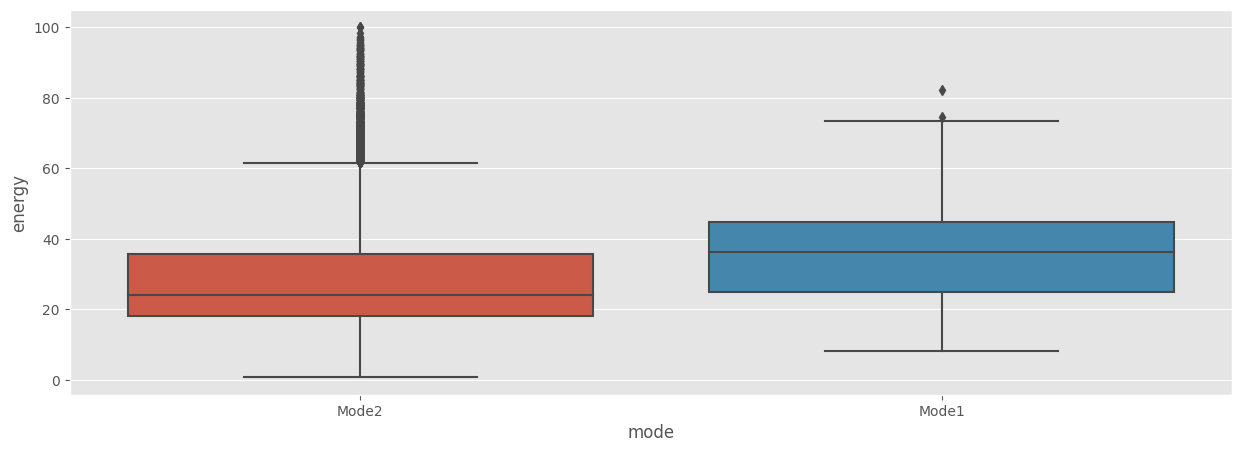

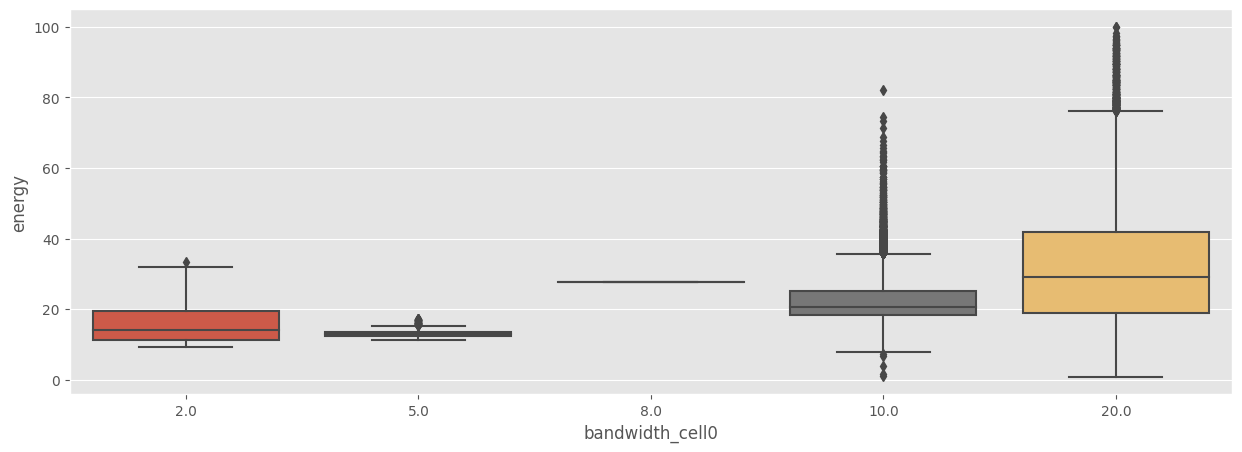

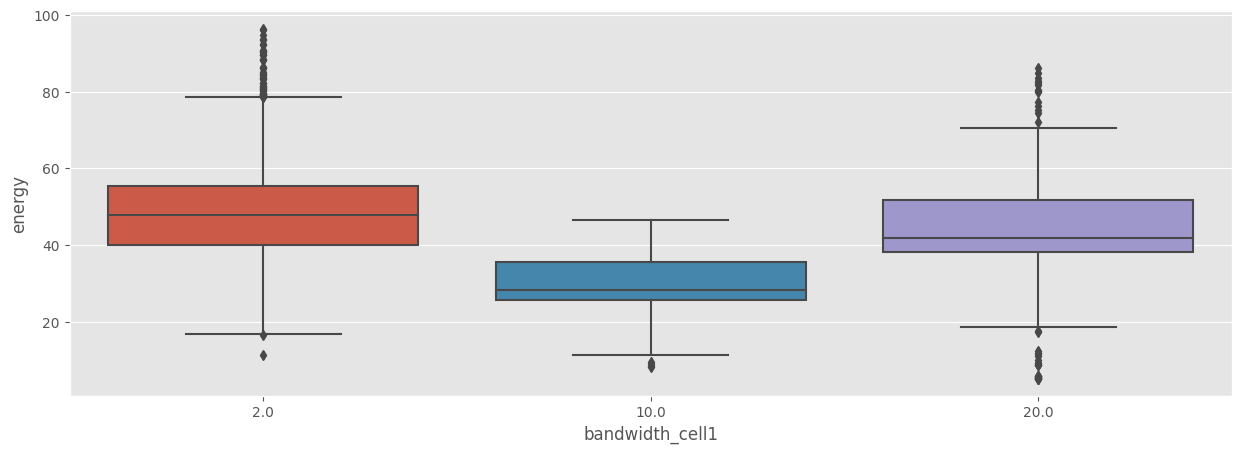

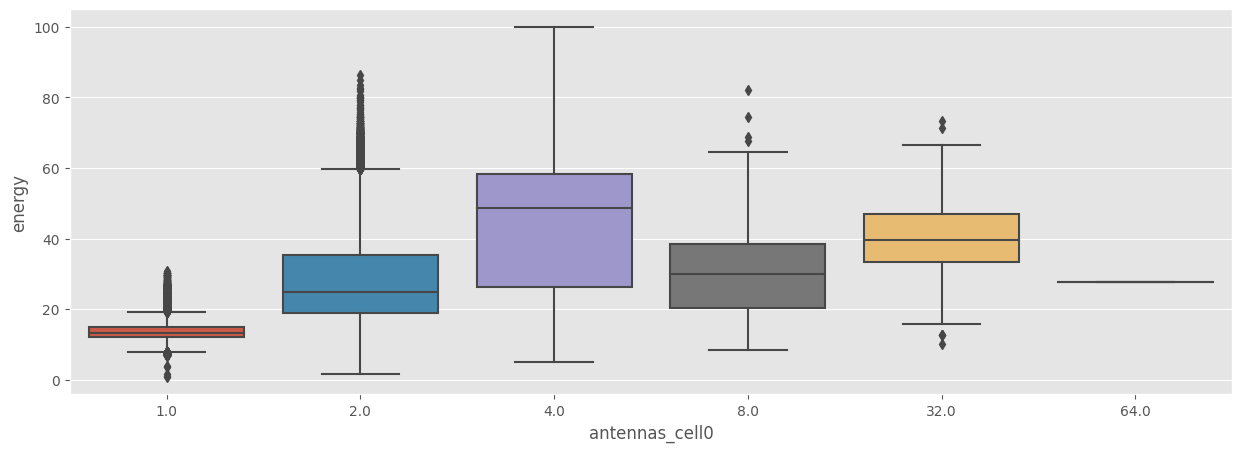

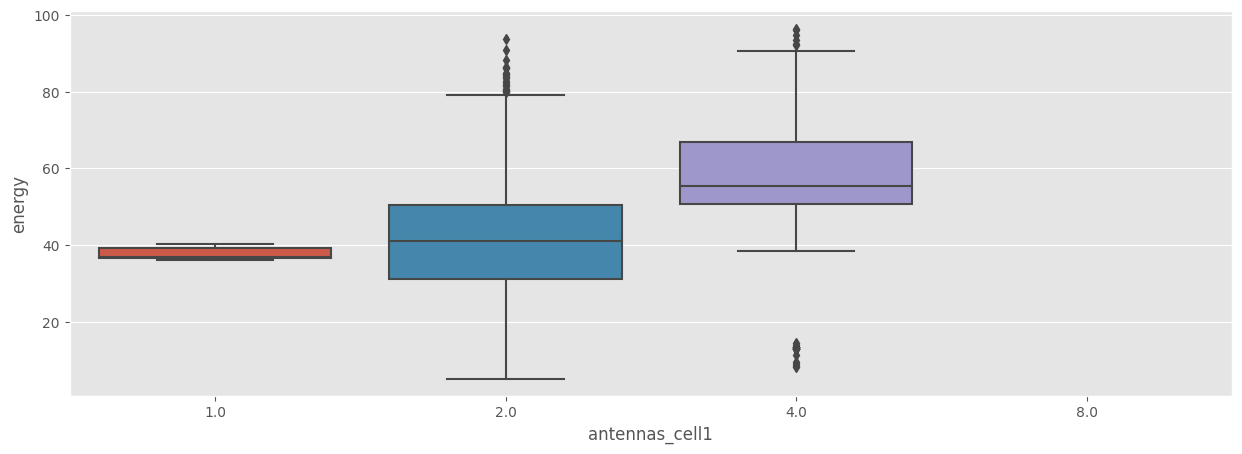

In [ ]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df, x=fe, y='energy')
    plt.show()

In [ ]:
def plot_cat_train_test_dist(df, fe_name, hue='split'):

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))

    # Plot the distribution plot on the first subplot
    sns.countplot(data=df[df['split'] == 'train'], ax=axes[0], x=fe_name)
    axes[0].set_title('Train Count Plot')

    # Plot the box plot on the second subplot
    sns.countplot(data=df[df['split'] == 'test'], ax=axes[1], x=fe_name)
    axes[1].set_title('Test Count Plot')

    sns.countplot(data=df, ax=axes[2], x=fe_name, hue='split')
    axes[2].set_title('Train & Test Count Plot')

    plt.show()

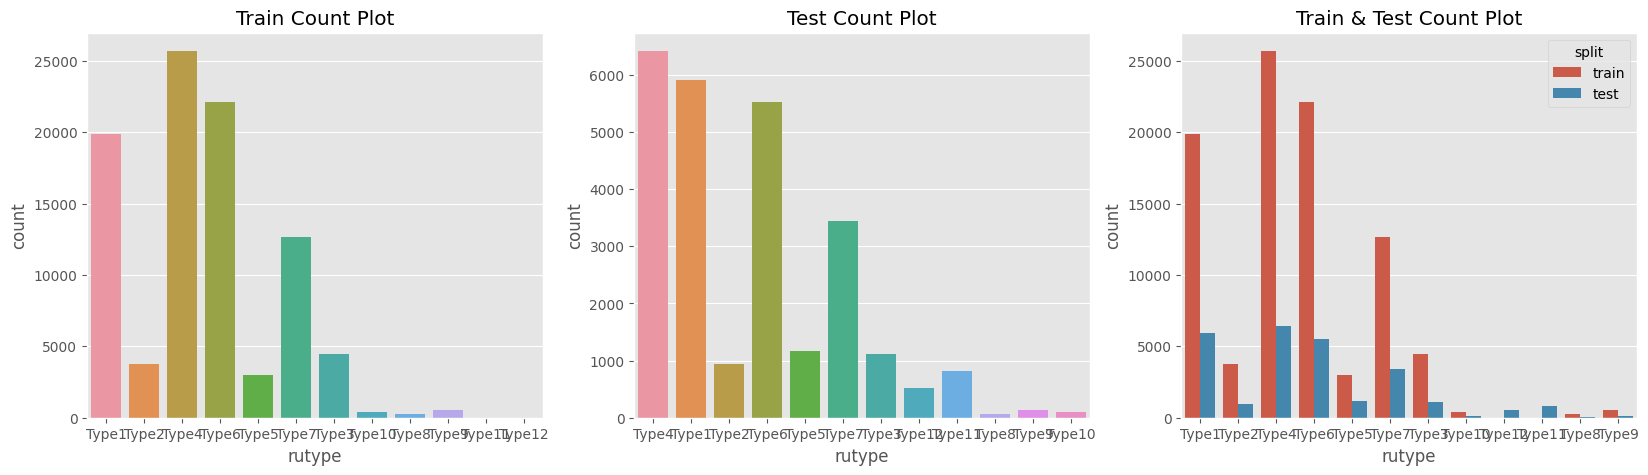

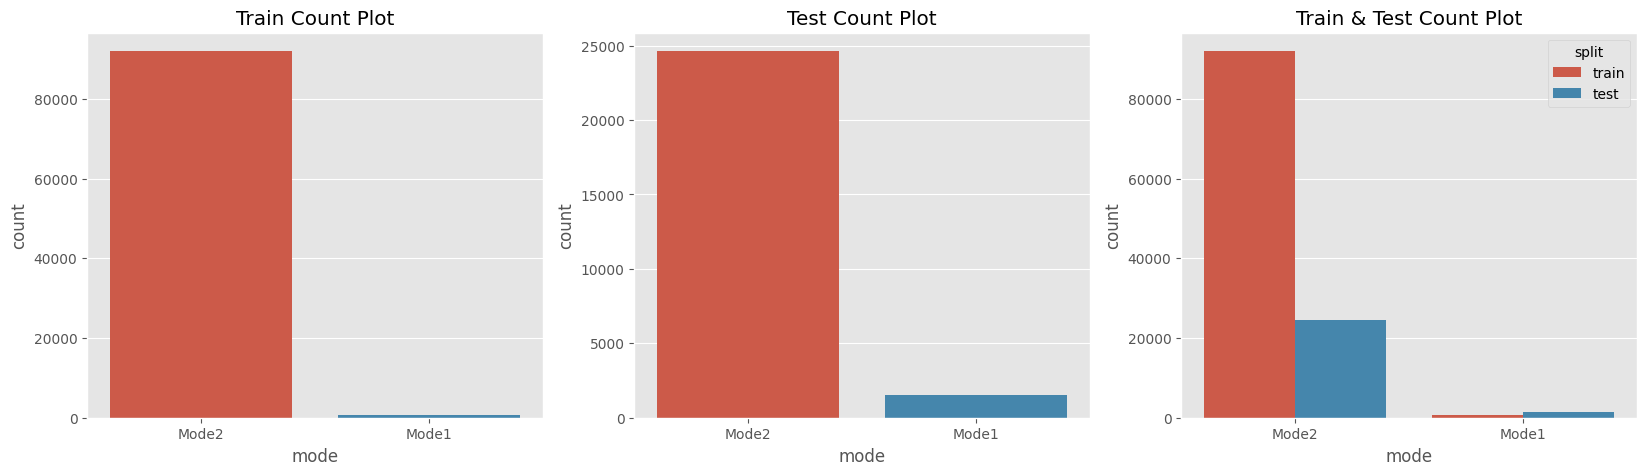

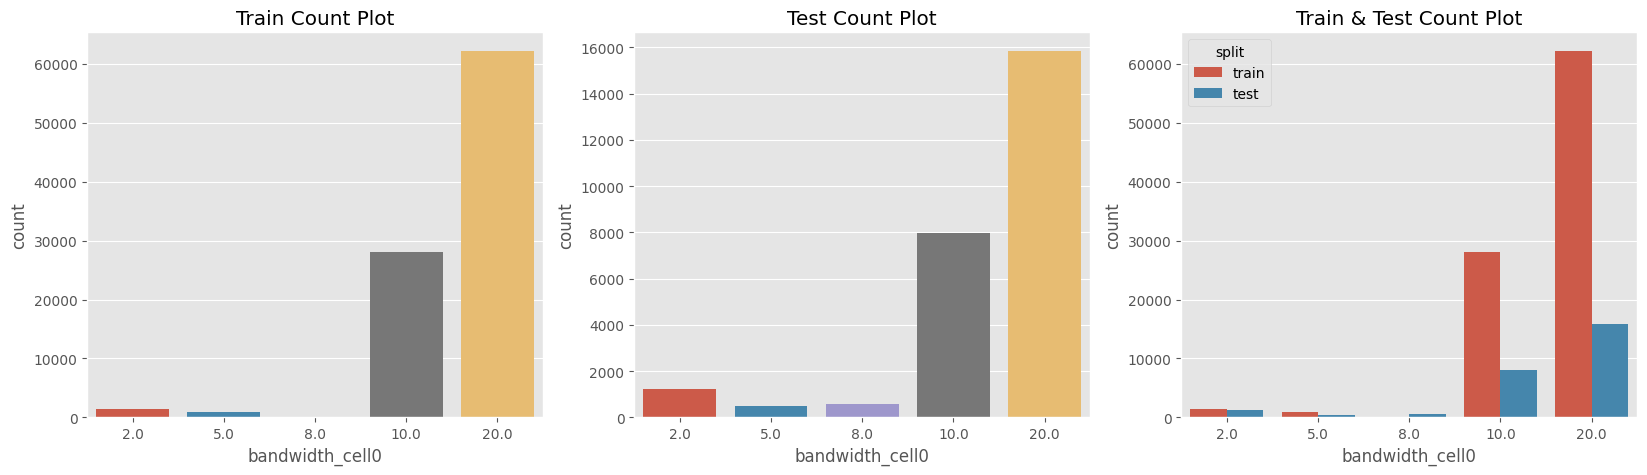

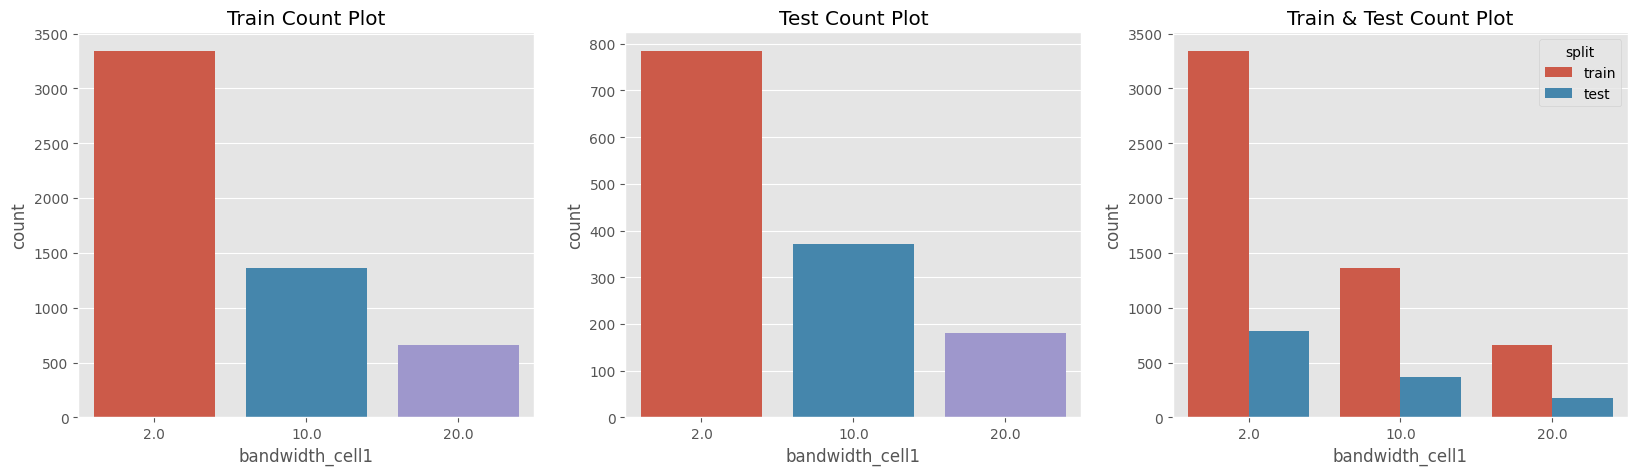

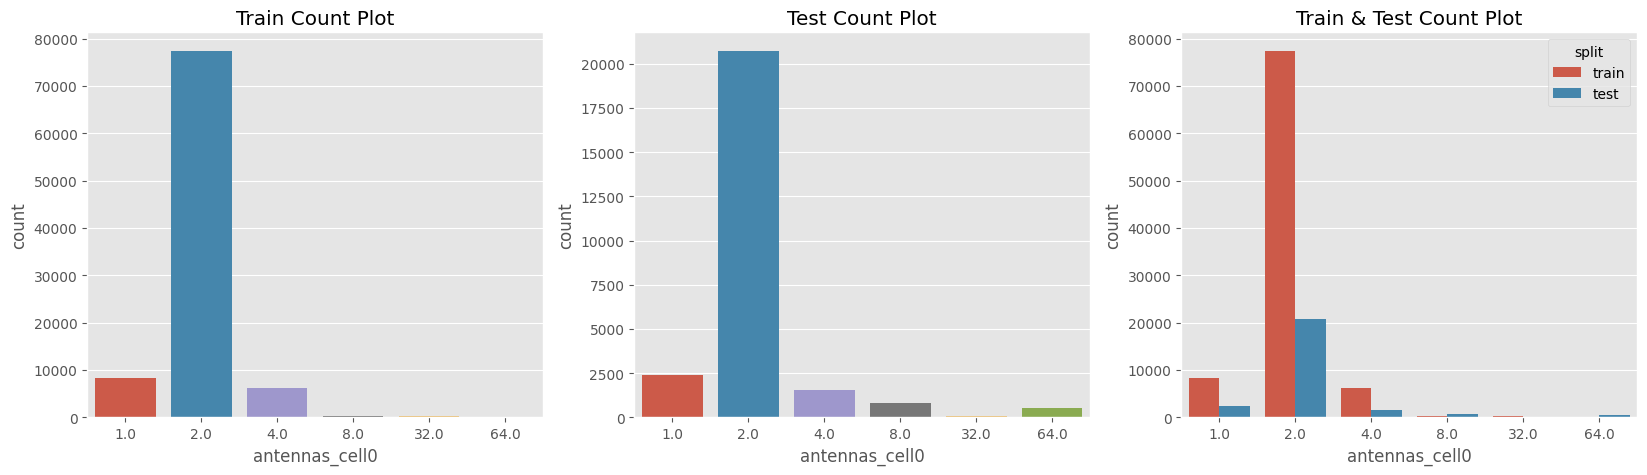

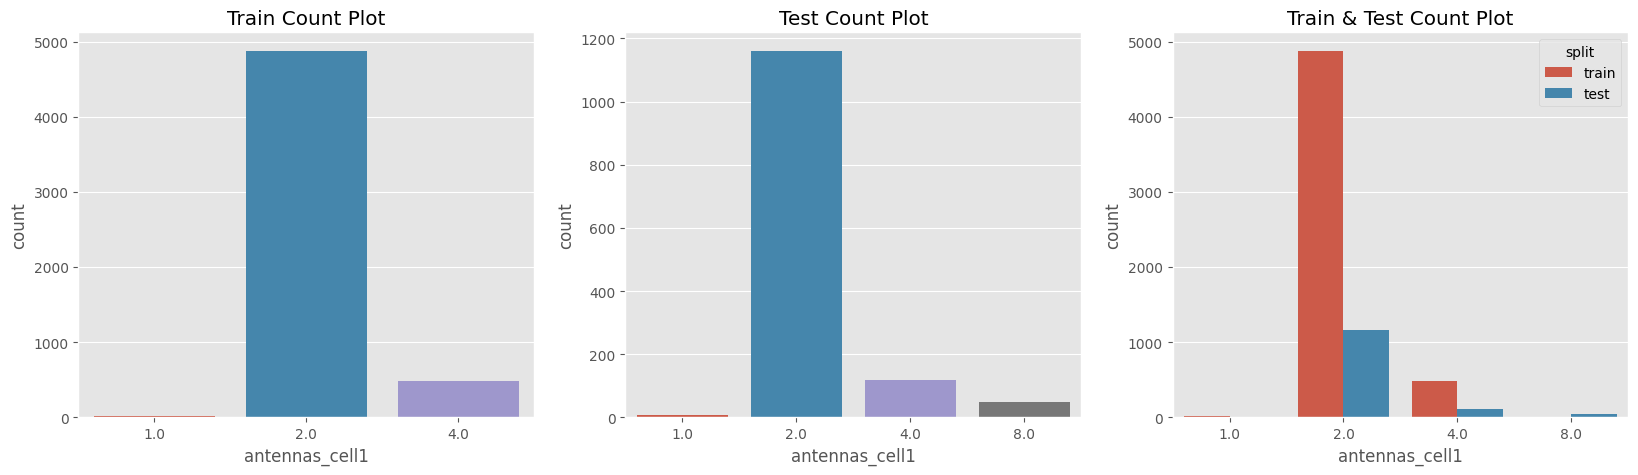

In [ ]:
for fe in ['rutype', 'mode', 'bandwidth_cell0', 'bandwidth_cell1', 'antennas_cell0', 'antennas_cell1']:
    plot_cat_train_test_dist(df=df, fe_name=fe, hue='split')

In [ ]:
df.groupby("split")['rutype'].value_counts().sort_index()

split  rutype
test   Type1      5908
       Type10      101
       Type11      815
       Type12      527
       Type2       939
       Type3      1111
       Type4      6419
       Type5      1164
       Type6      5521
       Type7      3446
       Type8        58
       Type9       130
train  Type1     19902
       Type10      403
       Type11        1
       Type12        1
       Type2      3757
       Type3      4442
       Type4     25677
       Type5      2974
       Type6     22083
       Type7     12641
       Type8       230
       Type9       518
Name: rutype, dtype: int64

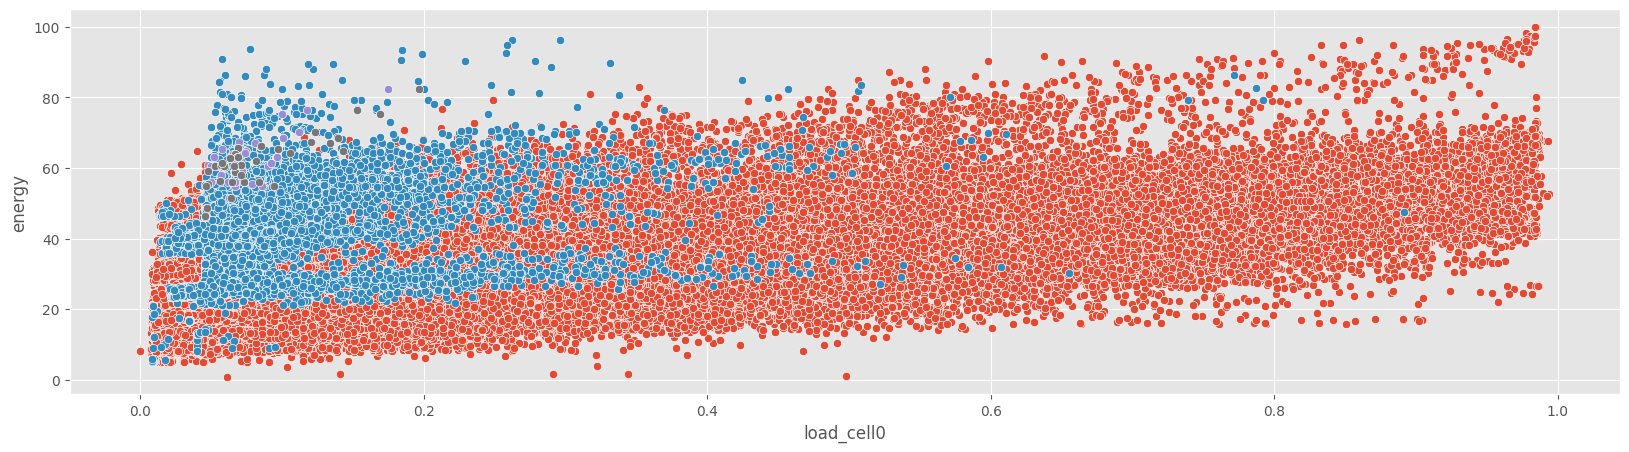

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='load_cell3', y='energy')
plt.show()

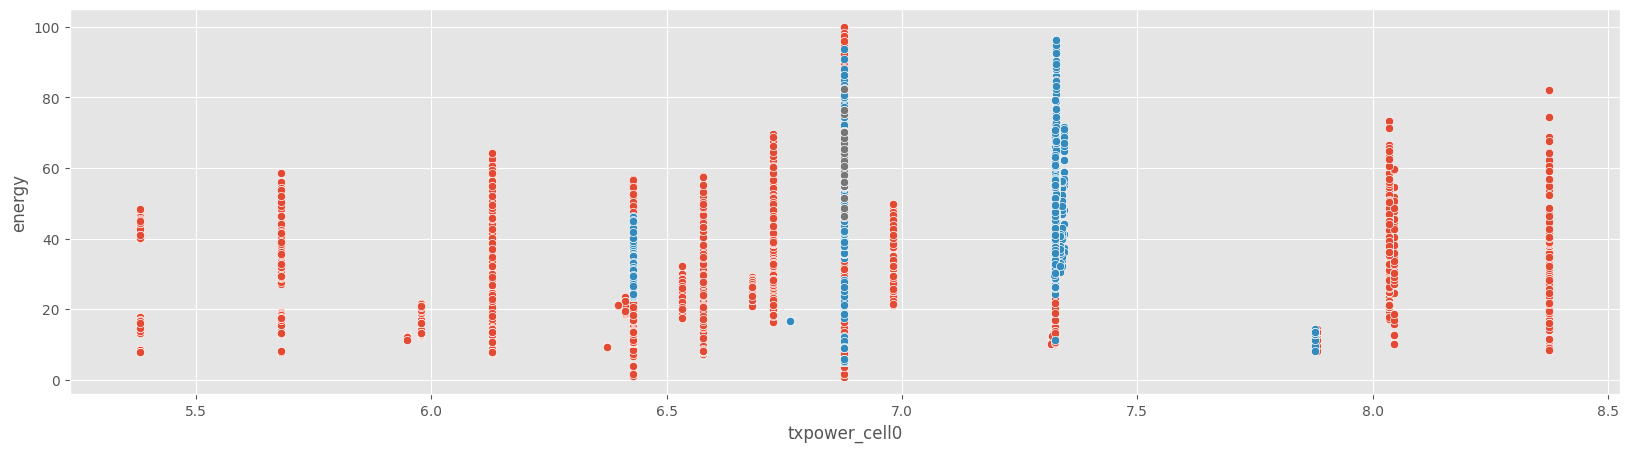

In [ ]:
plt.figure(figsize=(20, 5))
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell0', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell1', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell2', y='energy')
sns.scatterplot(data=df[df['split'] == 'train'], x='txpower_cell3', y='energy')
plt.show()

## Modeling

In [ ]:
train_data = df[df['split'] =='train']
test_data = df[df['split'] =='test']

train_data.shape, test_data.shape

((92629, 50), (26139, 50))

In [ ]:
def feature_enginning(train_df, valid_df, test_df):

    train_df['hour'] = train_df['time'].dt.hour
    valid_df['hour'] = valid_df['time'].dt.hour
    test_df['hour'] = test_df['time'].dt.hour

    # target_encoder = TargetEncoder(min_samples_leaf=1)
    # train_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.fit_transform(X=train_df[['rutype', 'mode', 'hour', 'bs']], y=train_df['energy'])
    # valid_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=valid_df[['rutype', 'mode', 'hour', 'bs']])
    # test_df[['te_rutype', 'te_mode', 'te_hour', 'te_bs']] = target_encoder.transform(X=test_df[['rutype', 'mode', 'hour', 'bs']])

    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    df['bs_en'] = df['bs'].apply(lambda x: int(x.strip('B_')))

    # df['rutype'] = df['rutype'].apply(lambda x: int(x.strip('Type')))
    # df['mode'] = df['mode'].apply(lambda x: int(x.strip('Mode')))

    df = pd.get_dummies(df, columns=['rutype',  'mode', 'hour'])

    df.sort_values(['time', 'bs'], inplace=True)
    # for fe in ['antennas_cell0', 'antennas_cell1', 'antennas_cell2', 'antennas_cell3', 'load_cell0', 'load_cell1',
    #    'load_cell2', 'load_cell3', 'txpower_cell0', 'txpower_cell1', 'txpower_cell2', 'txpower_cell3']:
    #     for r in [3, 5, 8, 10, 15]:
    #         df[f'r{r}_mean_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).mean())
    #         df[f'r{r}_std_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).std())
    #         df[f'r{r}_skew_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).skew())
    #         df[f'r{r}_max_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).max())

    # Target rolling
    # for fe in ['energy']:
    #     for r in [3, 5, 8, 10, 15]:
    #         df[f'r{r}_mean_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).mean().shift(1))
    #         df[f'r{r}_std_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).std().shift(1))
    #         df[f'r{r}_skew_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).skew().shift(1))
    #         df[f'r{r}_max_{fe}'] = df.groupby(['bs'])[f'{fe}'].transform(lambda x: x.rolling(r, min_periods=1).max().shift(1))


    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

In [ ]:
target_col = 'energy'
drop_cols = ['time', 'bs', 'split', target_col]

In [ ]:
train_data.columns

Index(['time', 'bs', 'load_cell0', 'load_cell1', 'load_cell2', 'load_cell3',
       'esmode1_cell0', 'esmode1_cell1', 'esmode1_cell2', 'esmode1_cell3',
       'esmode2_cell0', 'esmode2_cell1', 'esmode2_cell2', 'esmode2_cell3',
       'esmode3_cell0', 'esmode3_cell1', 'esmode3_cell2', 'esmode3_cell3',
       'esmode4_cell0', 'esmode4_cell1', 'esmode4_cell2', 'esmode4_cell3',
       'esmode5_cell0', 'esmode5_cell1', 'esmode5_cell2', 'esmode5_cell3',
       'esmode6_cell0', 'esmode6_cell1', 'esmode6_cell2', 'esmode6_cell3',
       'frequency_cell0', 'frequency_cell1', 'frequency_cell2',
       'frequency_cell3', 'bandwidth_cell0', 'bandwidth_cell1',
       'bandwidth_cell2', 'bandwidth_cell3', 'antennas_cell0',
       'antennas_cell1', 'antennas_cell2', 'antennas_cell3', 'txpower_cell0',
       'txpower_cell1', 'txpower_cell2', 'txpower_cell3', 'rutype', 'mode',
       'energy', 'split'],
      dtype='object')

In [ ]:
# remove the
train_data.columns

Index(['time', 'bs', 'load_cell0', 'load_cell1', 'load_cell2', 'load_cell3',
       'esmode1_cell0', 'esmode1_cell1', 'esmode1_cell2', 'esmode1_cell3',
       'esmode2_cell0', 'esmode2_cell1', 'esmode2_cell2', 'esmode2_cell3',
       'esmode3_cell0', 'esmode3_cell1', 'esmode3_cell2', 'esmode3_cell3',
       'esmode4_cell0', 'esmode4_cell1', 'esmode4_cell2', 'esmode4_cell3',
       'esmode5_cell0', 'esmode5_cell1', 'esmode5_cell2', 'esmode5_cell3',
       'esmode6_cell0', 'esmode6_cell1', 'esmode6_cell2', 'esmode6_cell3',
       'frequency_cell0', 'frequency_cell1', 'frequency_cell2',
       'frequency_cell3', 'bandwidth_cell0', 'bandwidth_cell1',
       'bandwidth_cell2', 'bandwidth_cell3', 'antennas_cell0',
       'antennas_cell1', 'antennas_cell2', 'antennas_cell3', 'txpower_cell0',
       'txpower_cell1', 'txpower_cell2', 'txpower_cell3', 'rutype', 'mode',
       'energy', 'split'],
      dtype='object')

In [ ]:
removing_cols = ['esmode3_cell0','esmode3_cell1','esmode3_cell2','esmode3_cell3','esmode4_cell0','esmode4_cell1','esmode4_cell2','esmode4_cell3','esmode5_cell0','esmode5_cell1','esmode5_cell2','esmode5_cell3']
train_data.drop(columns = removing_cols,axis=1,inplace=True)
test_data.drop(columns = removing_cols,axis=1,inplace=True)
train_data.head()

,time,bs,load_cell0,load_cell1,load_cell2,load_cell3,esmode1_cell0,esmode1_cell1,esmode1_cell2,esmode1_cell3,esmode2_cell0,esmode2_cell1,esmode2_cell2,esmode2_cell3,esmode6_cell0,esmode6_cell1,esmode6_cell2,esmode6_cell3,frequency_cell0,frequency_cell1,frequency_cell2,frequency_cell3,bandwidth_cell0,bandwidth_cell1,bandwidth_cell2,bandwidth_cell3,antennas_cell0,antennas_cell1,antennas_cell2,antennas_cell3,txpower_cell0,txpower_cell1,txpower_cell2,txpower_cell3,rutype,mode,energy,split
0,2023-01-01 01:00:00,B_0,0.487936,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,64.275037,train
1,2023-01-01 01:00:00,B_1,0.034770,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,4.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type2,Mode2,18.086697,train
2,2023-01-01 01:00:00,B_10,0.010457,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,365.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type1,Mode2,30.343797,train
4,2023-01-01 01:00:00,B_101,0.008720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,532.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.875934,NaN,NaN,NaN,Type4,Mode2,15.545590,train
5,2023-01-01 01:00:00,B_102,0.025720,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,189.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,6.427504,NaN,NaN,NaN,Type6,Mode2,17.488789,train


In [ ]:
# import numpy as np
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from sklearn.model_selection import KFold
# from sklearn import metrics

# # Define a simple neural network model
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_dim):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)  # Adjust the number of neurons as needed
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(64, 1)  # Output layer with a single neuron for regression

#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         return x

# # Initialize the neural network model
# input_dim = len(train_cols)
# model = NeuralNetwork(input_dim)

# # Define loss function and optimizer
# criterion = nn.MSELoss()  # Mean Squared Error loss for regression
# optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust learning rate as needed

# kf = KFold(n_splits=5, shuffle=True, random_state=42)  # You may want to set a random seed for reproducibility

# oof_valid_preds = np.zeros(train_data.shape[0])
# test_preds_list = []

# for i, (train_idx, valid_idx) in enumerate(kf.split(train_data)):
#     train_df = train_data.iloc[train_idx]
#     valid_df = train_data.iloc[valid_idx]
#     test_df = test_data.copy()

#     train_df, valid_df, test_df = feature_enginning(train_df=train_df, valid_df=valid_df, test_df=test_df)
#     train_cols = [col for col in train_df.columns if col not in drop_cols]

#     X_train, y_train = train_df[train_cols], train_df[target_col]
#     X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
#     X_test = test_df[train_cols]

#     # Convert data to PyTorch tensors
#     X_train = torch.FloatTensor(X_train.values)
#     y_train = torch.FloatTensor(y_train.values)
#     X_valid = torch.FloatTensor(X_valid.values)
#     y_valid = torch.FloatTensor(y_valid.values)

#     # Training the neural network
#     for epoch in range(100):  # You can adjust the number of epochs
#         optimizer.zero_grad()
#         outputs = model(X_train)
#         loss = criterion(outputs, y_train.view(-1, 1))
#         loss.backward()
#         optimizer.step()

#     # Make predictions on the validation set
#     valid_preds = model(X_valid).detach().numpy().flatten()
#     test_preds = model(torch.FloatTensor(X_test.values)).detach().numpy().flatten()

#     val_score = metrics.mean_absolute_error(y_valid, valid_preds)
#     oof_valid_preds[valid_idx] = valid_preds
#     test_preds_list.append(test_preds)

#     print("=*"*50)
#     print(f"Fold : {i}")
#     print(f"Valid score : {val_score}")

# oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
# print("_-*"*50)
# print(f"OOF score : {oof_score}")


In [ ]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 87.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.3/150.3 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.1/148.1 kB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics

from mlflow import log_metric, log_param, log_params, log_artifacts

kf = KFold(n_splits=5, shuffle=True, random_state=42)  # You may want to set a random seed for reproducibility

oof_valid_preds = np.zeros(train_data.shape[0])
test_preds_list = []

for i, (train_idx, valid_idx) in enumerate(kf.split(train_data)):

    train_df = train_data.iloc[train_idx]
    valid_df = train_data.iloc[valid_idx]
    test_df = test_data.copy()

    train_df, valid_df, test_df = feature_enginning(train_df=train_df, valid_df=valid_df, test_df=test_df)
    train_cols = [col for col in train_df.columns if col not in drop_cols]

    X_train, y_train = train_df[train_cols], train_df[target_col]
    X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
    X_test = test_df[train_cols]

    params = {
        'objective': 'reg:squarederror',  # Use 'reg:squarederror' for regression
        'n_jobs': -1,
        'max_depth': 6,  # Adjust the max depth as needed
        'n_estimators': 100,  # You can use a large number of boosting rounds
        'learning_rate': 0.01,
    }

    model = XGBRegressor(**params)

    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=100,  # Early stopping
        verbose=100
    )

    valid_preds = model.predict(X_valid)
    test_preds = model.predict(X_test)

    val_score = metrics.mean_absolute_error(y_valid, valid_preds)
    oof_valid_preds[valid_idx] = valid_preds
    test_preds_list.append(test_preds)

    print("=*"*50)
    print(f"Fold : {i}")
    print(f"Valid score : {val_score}")

oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
print("_-*"*50)
print(f"OOF score : {oof_score}")


[0]	validation_0-rmse:13.79644
[99]	validation_0-rmse:6.52036
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 0
Valid score : 5.239351483379433
[0]	validation_0-rmse:13.88290
[99]	validation_0-rmse:6.54433
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 1
Valid score : 5.240882316490282
[0]	validation_0-rmse:13.75183
[99]	validation_0-rmse:6.42648
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 2
Valid score : 5.1713443343894125
[0]	validation_0-rmse:13.91884
[99]	validation_0-rmse:6.57560
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 3
Valid score : 5.266691547655503
[0]	validation_0-rmse:13.70477
[99]	validation_0-rmse:6.45546
=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*=*
Fold : 4
Valid score

In [ ]:
# kf = model_selection.KFold(n_splits=5)
# kf = kf.split(X=train_data)

# oof_valid_preds = np.zeros(train_data.shape[0], )
# test_preds_list = []

# for i, (train_idx, valid_idx) in enumerate(kf):

#     train_df = train_data.iloc[train_idx]
#     valid_df = train_data.iloc[valid_idx]
#     test_df = test_data.copy()

#     train_df, valid_df, test_df = feature_enginning(train_df=train_df, valid_df=valid_df, test_df=test_df)
#     train_cols = [col for col in train_df.columns if col not in drop_cols]

#     X_train, y_train = train_df[train_cols], train_df[target_col]
#     X_valid, y_valid = valid_df[train_cols], valid_df[target_col]
#     X_test = test_df[train_cols]

#     params = {
#         'objective': 'regression',
#         'boosting_type': 'gbdt',
#         # 'learning_rate': 0.01,
#         'n_jobs': -1,
#         'max_depth' : -1,
#         'metric': 'mae',
#         'num_boost_round': 10000,
#     }

#     model = lgb.LGBMRegressor(**params)

#     early_stopping_callback = lgb.early_stopping(100, first_metric_only=True, verbose=False)
#     verbose_callback = lgb.log_evaluation(100)

#     model.fit(
#         X_train, y_train,
#         eval_set=[(X_valid, y_valid)],
#         callbacks=[early_stopping_callback, verbose_callback],
#     )

#     valid_preds = model.predict(X_valid)
#     test_preds = model.predict(X_test)

#     val_score = metrics.mean_absolute_error(y_valid, valid_preds)
#     oof_valid_preds[valid_idx] = valid_preds
#     test_preds_list.append(test_preds)

#     print("=*"*50)
#     print(f"Fold : {i}")
#     print(f"Valid score : ", val_score)

# oof_score = metrics.mean_absolute_error(train_data[target_col], oof_valid_preds)
# print("_-*"*50)
# print(f"OOF score : ", oof_score)

In [ ]:
test_preds_list

In [ ]:
test_preds_mean = np.mean(test_preds_list, axis=0)

In [ ]:
test_preds_mean

In [ ]:
test_preds_mean.shape

In [ ]:
test_data.shape

In [ ]:
test_data['Energy'] = test_preds_mean

In [ ]:
test_data['Energy'].hist()

In [ ]:
ss_df.head()

In [ ]:
test_data['ID'] = test_data['time'].astype('str') + '_' + test_data['bs']

In [ ]:
test_data[['ID', 'Energy']]

In [ ]:
ss_df['ID'] = ss_df['Time'].astype('str') + '_' + ss_df['BS']


In [ ]:
ss_df = ss_df[['ID']]
ss_df = ss_df.merge(test_data[['ID', 'Energy']], on='ID', how='left')

In [ ]:
ss_df.head()

In [ ]:
ss_df.to_csv("base_model_submission.csv", index=False)